# Building WaveNet

### Importing necessary libraries

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

### Reading the data

In [4]:
# read in all the words
words = open('./data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


### Building the Vocabulory

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
## Shuffle the words

random.seed(42)
random.shuffle(words)

### Building the dataset

In [9]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix] # Crop and Append
            
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y      

In [10]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [11]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


### Developing the MLP Layers: Similar to Pytorch

In [53]:
## Define the Linear Layer
# -----------------------------------------------------------------------------------------------

class Linear:
    
    def __init__(self, fan_in : int, fan_out : int, bias : bool = True):
        self.weight = torch.randn((fan_in, fan_out))/fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    ## Calculating the Forward Pass
    def __call__(self, x):
        
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
        
    def parameters(self):
        
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
## Define the BatchNorm Layer
# -----------------------------------------------------------------------------------------------

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        
        self.eps = eps
        self.momentum = momentum # Factor the weight of the contribution of running mean
        self.training = True # Similar to pytorch
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        
        ## Calutaing the Forward Pass
        if self.training:
            
#             if x.ndim == 2:
#                 dim = 0
#             elif x.ndim == 3:
#                 dim = (0,1)
            
            xmean = x.mean(0, keepdims = True)
            xvar = x.var(0, keepdims = True)
        else:
            xmean, xvar = self.running_mean, self.running_var
        
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma*xhat + self.beta
        
        if self.training:
            ## No need to backprop through running_mean or running_var
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
                
        return self.out
        
    def parameters(self):
        
        return [self.gamma, self.beta]
    

## Define the Embedding Layer
# -----------------------------------------------------------------------------------------------

class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        
        return [self.weight]
    

## Define the Sequential Class : Multiple linear layers stacked together
# -----------------------------------------------------------------------------------------------

class Sequential:
    
    def __init__(self, layers):
        
        self.layers = layers
        
    def __call__(self, x):
        
        for layer in self.layers:
            x = layer(x)
            
        self.out = x
        return self.out
    
    def parameters(self):
        
        return [p for layer in self.layers for p in layer.parameters()]
    
## Define the Tanh Layer
# -----------------------------------------------------------------------------------------------

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
        

### Setting the seed

In [55]:
torch.manual_seed(42)

### Defining a Network

In [56]:
n_embd, n_hidden = 10, 200
C = torch.randn((vocab_size, n_embd))

layers = [Linear((n_embd*block_size), n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(), Linear(n_hidden, vocab_size, bias = True),]

# Make the last Softmax Layer less Confident
with torch.no_grad():
    layers[-1].weight *= 0.1
    
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

## Setting requires_grad
for p in parameters:
    p.requires_grad = True
    


22097


### Training the network

In [57]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Construct the mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #Forward pass
    emb = C[Xb] # embedd the characters into vectors
    x = emb.view(emb.shape[0], -1) # changing the dimensions for matrix multiplication
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss
    
    #Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    

      0/ 200000: 3.2847
  10000/ 200000: 2.0647
  20000/ 200000: 1.9722
  30000/ 200000: 2.0948
  40000/ 200000: 1.9738
  50000/ 200000: 2.1287
  60000/ 200000: 2.3574
  70000/ 200000: 1.9131
  80000/ 200000: 2.0735
  90000/ 200000: 2.0968
 100000/ 200000: 1.4963
 110000/ 200000: 2.1294
 120000/ 200000: 2.2324
 130000/ 200000: 2.2071
 140000/ 200000: 2.2326
 150000/ 200000: 1.8908
 160000/ 200000: 1.6867
 170000/ 200000: 2.0968
 180000/ 200000: 1.7824
 190000/ 200000: 1.9151


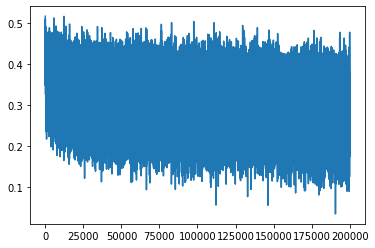

In [58]:
plt.plot(lossi)

##### Viewing the loss in a better way

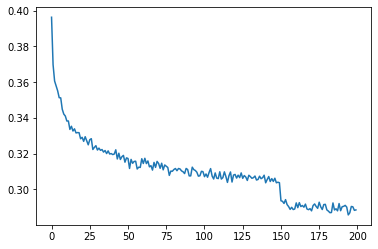

In [68]:
# Learning rate decay shows up prominently

plt.plot(torch.tensor(lossi).view(-1,1000).mean(dim = 1))

In [59]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
    layer.training = False

In [66]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    #Forward pass
    emb = C[x] # embedd the characters into vectors
    x = emb.view(emb.shape[0], -1) # changing the dimensions for matrix multiplication
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y) # loss
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9163438081741333
val 2.034248113632202


#### Sample from the model

In [67]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # embedd the characters into vectors
        x = emb.view(emb.shape[0], -1) # changing the dimensions for matrix multiplication
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

melae.
lynn.
gwesen.
macoy.
delia.
chrelan.
jaquin.
dayana.
haziyah.
hamilin.
dacy.
grayman.
abella.
kaklyn.
cash.
hamby.
dencelyuh.
card.
malizen.
ronni.


### Reducing more Boilerplate Code

In [70]:
## Define the Linear Layer
# -----------------------------------------------------------------------------------------------

class Linear:
    
    def __init__(self, fan_in : int, fan_out : int, bias : bool = True):
        self.weight = torch.randn((fan_in, fan_out))/fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    ## Calculating the Forward Pass
    def __call__(self, x):
        
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
        
    def parameters(self):
        
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
## Define the BatchNorm Layer
# -----------------------------------------------------------------------------------------------

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        
        self.eps = eps
        self.momentum = momentum # Factor the weight of the contribution of running mean
        self.training = True # Similar to pytorch
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        
        ## Calutaing the Forward Pass
        if self.training:
            
#             if x.ndim == 2:
#                 dim = 0
#             elif x.ndim == 3:
#                 dim = (0,1)
            
            xmean = x.mean(0, keepdims = True)
            xvar = x.var(0, keepdims = True)
        else:
            xmean, xvar = self.running_mean, self.running_var
        
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma*xhat + self.beta
        
        if self.training:
            ## No need to backprop through running_mean or running_var
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
                
        return self.out
        
    def parameters(self):
        
        return [self.gamma, self.beta]
    

## Define the Embedding Layer
# -----------------------------------------------------------------------------------------------

class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        
        return [self.weight]
    

## Define the Sequential Class : Multiple linear layers stacked together
# -----------------------------------------------------------------------------------------------

class Sequential:
    
    def __init__(self, layers):
        
        self.layers = layers
        
    def __call__(self, x):
        
        for layer in self.layers:
            x = layer(x)
            
        self.out = x
        return self.out
    
    def parameters(self):
        
        return [p for layer in self.layers for p in layer.parameters()]
    
## Define the Flatten Class: Change view of tensors
# -----------------------------------------------------------------------------------------------

class Flatten:
    
    def __call__(self, x):
        
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        
        return []

## Define the Tanh Layer
# -----------------------------------------------------------------------------------------------

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
        

#### Defining the network 

In [78]:
n_embd, n_hidden = 10, 200

model = Sequential([Embedding(vocab_size, n_embd), Flatten(), Linear((n_embd*block_size), n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(), Linear(n_hidden, vocab_size, bias = True),])

# Make the last Softmax Layer less Confident
with torch.no_grad():
    model.layers[-1].weight *= 0.1
    
parameters = [p for layer in model.layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

## Setting requires_grad
for p in parameters:
    p.requires_grad = True
    


22097


#### Training the network

In [79]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Construct the mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss
    
    #Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    

      0/ 200000: 3.2821
  10000/ 200000: 2.3583
  20000/ 200000: 2.4325
  30000/ 200000: 1.9561
  40000/ 200000: 2.1812
  50000/ 200000: 2.1122
  60000/ 200000: 2.0685
  70000/ 200000: 2.0697
  80000/ 200000: 2.1763
  90000/ 200000: 1.8765
 100000/ 200000: 2.4572
 110000/ 200000: 2.2537
 120000/ 200000: 1.7612
 130000/ 200000: 2.3858
 140000/ 200000: 2.1563
 150000/ 200000: 2.2024
 160000/ 200000: 2.0269
 170000/ 200000: 2.0685
 180000/ 200000: 1.8371
 190000/ 200000: 2.2245


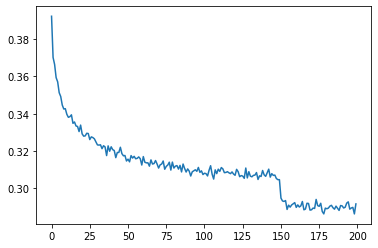

In [80]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [81]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

#### Evaluate dev and train loss

In [82]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.920302391052246
val 2.0265724658966064


#### Sample from the model

In [83]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

keamyr.
khalix.
bingermuns.
renilio.
lehan.
bright.
rizana.
garkens.
ilemar.
xhava.
imaylyn.
gracyne.
leselon.
aphiduge.
mikalai.
michaely.
arrilyn.
serii.
aulyn.
kaylin.
